In [ ]:
!pip install scispacy
!pip install spacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz

KeyboardInterrupt: 

# Project Name and my name

In [ ]:
# Execute this cell after you have downloaded the files to /content/

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
# Load the downloaded JSON files into pandas DataFrames, specifying lines=True for JSON Lines format
train_df = pd.read_json('bc5cdr_train.json', lines=True)
validation_df = pd.read_json('bc5cdr_valid.json', lines=True) # Corrected filename
test_df = pd.read_json('bc5cdr_test.json', lines=True)


# Introduction


# Data

In [ ]:

# Display the first few rows of the training DataFrame to confirm loading
print("Train DataFrame head:")
display(train_df.head())

print("\nValidation DataFrame head:")
display(validation_df.head())

print("\nTest DataFrame head:")
display(test_df.head())

# label IDS
{
    "O": 0,
    "B-Chemical": 1,
    "B-Disease": 2,
    "I-Disease": 3,
    "I-Chemical": 4
}

# Method 1: CNN - scispaCy en_ner_bc5cdr_md
This model is specifically trained on the bc5cdr dataset, so this model will provide baseline metrics to benchmark other models against. Since it is already trained on the data, I will simply run load the model and run it against the training dataset.

In [ ]:
import scispacy
import spacy
nlp = spacy.load("en_ner_bc5cdr_md")

KeyboardInterrupt: 

In [ ]:
# split the test set into the data and labels
test_labels = test_df['tags'].tolist()
test_data = test_df['tokens'].tolist()
# transofrm the tokens into a list of strings of text
test_data = [" ".join(tokens) for tokens in test_df["tokens"]]
print(test_data[0])
print(test_labels[0])

In [ ]:
def char_to_token_bio(doc, tokens):
    text = doc.text
    offsets = []

    # compute character span of each token
    idx = 0
    for tok in tokens:
        start = text.find(tok, idx)
        end = start + len(tok)
        offsets.append((start, end))
        idx = end

    # initialize all as O
    bio = ["O"] * len(tokens)

    for ent in doc.ents:
        for i, (s, e) in enumerate(offsets):
            # token overlaps entity span?
            if s >= ent.start_char and e <= ent.end_char:
                prefix = "B-" if s == ent.start_char else "I-"
                bio[i] = prefix + ent.label_

    return bio


In [ ]:
test_data = [" ".join(tokens) for tokens in test_df["tokens"]]
docs = list(nlp.pipe(test_data))

predicted_tags = [
    char_to_token_bio(doc, tokens)
    for doc, tokens in zip(docs, test_df["tokens"])
]


In [ ]:
print(predicted_tags[0])

In [ ]:
label2id = {
    "O": 0,
    "B-CHEMICAL": 1,
    "B-DISEASE": 2,
    "I-DISEASE": 3,
    "I-CHEMICAL": 4
}


In [ ]:
# Convert to integers
predicted_ids = [
    [label2id[tag] for tag in seq]
    for seq in predicted_tags
]

In [ ]:
# Compare integers to test results
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Flatten the lists of lists into single 1D lists using list comprehension
y_true_flat = [item for sublist in test_labels for item in sublist]
y_pred_flat = [item for sublist in predicted_ids for item in sublist]

# Convert to numpy arrays
y_true = np.array(y_true_flat)
y_pred = np.array(y_pred_flat)

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print("Classification Report:")
# Create target names from the label2id dictionary keys
target_names = list(label2id.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
from tabulate import tabulate


# BiLSTM-CRF model


In [ ]:
!pip install pytorch-crf
!pip install seqeval
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score
import pandas as pd
import numpy as np

In [ ]:
# CONFIGURATION
BATCH_SIZE = 32
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
EPOCHS = 8 #
LEARNING_RATE = 0.001
MAX_GRAD_NORM = 1.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


In [ ]:
def build_vocab(dfs, existing_label2id):
  """Builds word-to-index and tag-to-index dictionaries, using existing_label2id for tags"""
  # build a dictionary to map every unique word to a int id
  words = set()
  # Only build the word vocabulary from tokens
  for df in dfs:
    for tokens in df['tokens']:
      words.update(tokens)

  word2idx = {word: idx + 2 for idx, word in enumerate(words)}
  word2idx["<PAD>"] = 0
  word2idx["<UNK>"] = 1

  # Use the provided label2id and derive idx2tag from it
  tag2idx = existing_label2id
  idx2tag = {idx: tag for tag, idx in tag2idx.items()}

  return word2idx, tag2idx, idx2tag

In [ ]:
word2idx, tag2idx, idx2tag = build_vocab([train_df, validation_df, test_df], label2id)
print("Word to Index mapping (sample):", list(word2idx.items())[:5])
print("Tag to Index mapping:", tag2idx)
print("Index to Tag mapping:", idx2tag)
print(f"Vocabulary size: {len(word2idx)}")
print(f"Number of unique tags: {len(tag2idx)}")

# NERDDataset Class Description

This `NERDDataset` class is a custom PyTorch `Dataset` designed to prepare Named Entity Recognition (NER) data for training and evaluation with PyTorch models. It handles the conversion of raw text tokens and their corresponding labels into numerical tensor formats required by neural networks.

### Key Features:
-   **Initialization (`__init__`)**: Takes a Pandas DataFrame containing 'tokens' (list of words) and 'tags' (list of integer labels), along with `word2idx` and `tag2idx` mappings. It stores these for data processing.
-   **Length (`__len__`)**: Returns the total number of samples (sentences) in the dataset.
-   **Item Retrieval (`__getitem__`)**: For a given index, it converts a sentence's words into numerical `token_ids` using `word2idx` (handling unknown words with an `<UNK>` token) and its labels into `tag_ids` using `tag2idx`. These numerical sequences are then returned as PyTorch tensors.

This class is essential for creating `DataLoader` instances, which efficiently feed batches of processed data to a PyTorch NER model during training and inference.
```

In [ ]:
# class NERDDataset
class NERDataset(Dataset):
  # constructor
  def __init__(self, df,word2idx,tag2idx):
    self.df = df
    self.word2idx = word2idx
    self.tag2idx = tag2idx
    self.tag_col = 'tags' if 'tags' in df.columns else 'ner_tags'
  # len method
  def __len__(self):
        return len(self.df)

  # return item
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    # Convert words to indices (use <UNK> if not found)
    token_ids = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in row['tokens']]
    # Tags are already integer IDs, so no need to map them again
    tag_ids = row[self.tag_col]

    return torch.tensor(token_ids), torch.tensor(tag_ids)

In [ ]:

def collate_fn(batch):
    """Pads sequences to the longest in the batch."""
    tokens, tags = zip(*batch)

    # Pad sequences
    # pad with 0 for tokens (<PAD>)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=word2idx["<PAD>"])

    # pad tags with 0 (or any valid integer).
    # The mask will ensure the model ignores this padding during loss calculation.
    # It is crucial that the padding value is an integer.
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=0)

    # Create mask (True for real words, False for padding)
    # Cast to boolean/byte for pytorch-crf
    mask = (tokens_padded != word2idx["<PAD>"]).byte()

    return tokens_padded, tags_padded, mask

In [ ]:
#Create DataLoaders
train_dataset = NERDataset(train_df, word2idx, tag2idx)
val_dataset = NERDataset(validation_df, word2idx, tag2idx)
test_dataset = NERDataset(test_df, word2idx, tag2idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Model Definition

Contructing BiLSTM-CRF model

**Include a description of the class here**

In [ ]:
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        # layer 1: embedding
        # turns integer ids into dense vectors
        # padding_idx=0 makes the embedding for <PAD> always zero vector, tells pytorch index 0 is fake dont learn a vector for it
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # layer 2: BiLSTM
        # bidectional true = creates two LSTMS one forward , one backward
        # batch_first= true means input shape is (batch, seq_length, features)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True)
        # layer 3: lienar projector
        # lstm ouputs a vector of size hidden_dim
        # need to shrink it to number of tags which is tagset size
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # layer 4: CRF
        # conditional random field layer
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x, mask, tags=None):
      # get embeddings
        embeds = self.embedding(x)
        # run Bilstm
        lstm_out, _ = self.lstm(embeds)
        # project to tag spcace- emissions
        # each score now has a score for being B-disease, I-chemical etc
        emissions = self.hidden2tag(lstm_out)

# TRAINING MODE:
# w/ true tags calculate negative log likelhood loss
# The CRF calculates: P(True_Path) / Sum(P(All_Possible_Paths))
# We return negative because we want to MINIMIZE loss (make prob closer to 1).
        if tags is not None:
            # Training: Return negative log likelihood loss
            # pytorch-crf returns log likelihood, so we negate it
            # IMPORTANT: Pass the mask! tells CRF to ignore padding so it doesnt try and learn it
            log_likelihood = self.crf(emissions, tags, mask=mask)
            return -log_likelihood
        else:
          # inference mode
          # if we dont have tags tell CRF to find the best path
            # Prediction: Return best path with the highest total score
            return self.crf.decode(emissions, mask=mask)

model = BiLSTM_CRF(len(word2idx), len(tag2idx), EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


# Instiantiating the model

Details


# Training Loop

details

In [ ]:
print("\nStarting training...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        tokens_batch, tags_batch, mask_batch = [b.to(DEVICE) for b in batch]

        optimizer.zero_grad()

        # Forward pass (returns loss because we provide tags)
        loss = model(tokens_batch, mask_batch, tags_batch)

        # Backward pass
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")

# Evaluating BiLSTM

In [ ]:

print("\nEvaluating on Test Set...")
model.eval()

true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        tokens_batch, tags_batch, mask_batch = [b.to(DEVICE) for b in batch]
        # get the predictions (list of lists of tag indices)
        predictions = model(tokens_batch, mask_batch)

        # align predictions and true labels using mask
        # preidctions from CRD decode already exclude masked itemsm but tags_batch is padded
        for i,pred in enumerate(predictions):

          # pred is a list of indices for the valid tokens only
          valid_len = len(pred)

          # get the corresponding true tags , slicing off padding
          true_tag_indices = tags_batch[i][:valid_len].cpu().tolist()

          # convert to strings for seqeval
          true_names = [idx2tag[idx] for idx in true_tag_indices]
          pred_names = [idx2tag[idx] for idx in pred]

          true_labels.append(true_names)
          pred_labels.append(pred_names)

# --- Token-level evaluation (including B- and I- tags) ---
print("\nToken-Level Classification Report (with B- and I- tags):")
import numpy as np
from sklearn.metrics import classification_report as sklearn_classification_report

y_true_flat_sklearn = [item for sublist in true_labels for item in sublist]
y_pred_flat_sklearn = [item for sublist in pred_labels for item in sublist]

target_names_sklearn = [idx2tag[i] for i in sorted(idx2tag.keys())]

LSTM_Report = sklearn_classification_report(y_true_flat_sklearn, y_pred_flat_sklearn, labels=target_names_sklearn, zero_division=0)

print(LSTM_Report)

# Convert to DataFrame
#report_df = pd.DataFrame(LSTM_Report)
#report_df

# can save as a csv
#report_df.to_csv("BiLSTM_results.csv")

# Discussion of Results for BiLSTM -CRF

The BiLSTM acheived significantly lower scores for most entities. the model acheived comparable scores for identifying O (non-chemical or disease entiuties) which suggests that non-chemical and non-disease entities are easily indetifiable since both models achieved high f-1 scores on non-entities. Precision recall and f-1 score were >10% lower compared to scispaCy approach (CNN model) for B-chemical, B-disease, and I -cehncial and I-chemcial. intesresttingly enough the model has a simialy low F-1 score on I-Chemical classification, suggesting that both models stuggle to perform NER on multi-word chemical entities.

# BIOBERT Approach

In [ ]:
# load in the model using automodel from huggingface
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from datasets import Dataset,DatasetDict # Import Dataset from the datasets library
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(validation_df)
test_dataset = Dataset.from_pandas(test_df)
raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})
# --- 2. Tokenization & Label Alignment  ---
model_checkpoint = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
#  need the label mapping to know which ID corresponds to which 'B-' tag
# so we can convert it to 'I-' for sub-tokens.
label_list = ["O", "B-CHEMICAL", "B-DISEASE", "I-DISEASE", "I-CHEMICAL"]
# Create a map to convert B- tag IDs to their corresponding I- tag IDs
#  If B-CHEMICAL is 1 and I-CHEMICAL is 4, then b_to_i[1] = 4
b_to_i = {1: 4, 2: 3}

the autojenizer uses wordpiece to tokenize the text, which is a subword tokenization method,meaning that a list of tokens like ["Hydrochlorothiazide", "is", "a", "drug"] will be broken into subwords by the tokenizer, resulting in something like ["Hydro", "##chloro", "##thia", "##zide", "is", "a", "drug"]. This will cause alignment issues during training since the tags are based on the complete words, so the tag list will be list of length 4 like [B-CHEMCIAL, O,O,O], but the token list is 7 units long.  The list needs to be matched to the first sub-token of the word, and ignoring the rest. so the list ["Hydro", "##chloro", "##thia", "##zide", "is", "a", "drug"] would be tagged like [B-CHEMICAL, -100,-100,O,O,O] and the tokenizer will ignore -100.


In [ ]:
from math import trunc
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # Start of a new word: Use the original label
                label_ids.append(label[word_idx])
            else:
                # Sub-word:
                #  Propagate the label
                # If the word was "B-Chemical", the sub-token should be "I-Chemical"
                original_label = label[word_idx]
                if original_label in b_to_i:
                    label_ids.append(b_to_i[original_label])
                else:
                    # If it was already 'O' or 'I-', keep it.
                    label_ids.append(original_label)

            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs
tokenized_datasets = raw_datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5330 [00:00<?, ? examples/s]

Map:   0%|          | 0/5865 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification
from transformers import pipeline

id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
model = AutoModelForTokenClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.2",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

data_collator = DataCollatorForTokenClassification(tokenizer)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# compute metricsm called during eval
from seqeval.metrics import f1_score, precision_score, recall_score
def compute_metrics(p):
  predictions,labels = p
  predictions = np.argmax(predictions, axis=2)

  # removed ignored indexes ( special tokens)
  true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
  true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
  ]
  # return a ductionary
  return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [ ]:
# training parameters
!pip install evaluate
import evaluate
from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    "biobert-ner",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.1,
    metric_for_best_model="f1",
    load_best_model_at_end=True, # Load the best epoch, not the last one
    push_to_hub=False,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
# init Trainer object
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-4222198753.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# train
trainer.train()

AttributeError: `AcceleratorState` object has no attribute `distributed_type`. This happens if `AcceleratorState._reset_state()` was called and an `Accelerator` or `PartialState` was not reinitialized.

In [ ]:
# --- 5. Word-Level Evaluation ---
print("Generating WORD-LEVEL classification report...")

# 1. Get raw predictions
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

# 2. Reconstruct Word-Level Predictions
# map sub-tokens back to words using the 'word_ids'  saved
true_labels_word_level = []
pred_labels_word_level = []

# Iterate through each sentence in the test set
for i, example in enumerate(tokenized_datasets["test"]):
    # Get the word_ids for this sentence (maps sub-tokens to word indices)
    # Example: [None, 0, 1, 1, 1, 2, None] -> CLS, Word0, Word1(sub1), Word1(sub2)...
    word_ids = example["word_ids"] if "word_ids" in example else tokenizer(
        test_dataset[i]["tokens"], truncation=True, is_split_into_words=True
    ).word_ids()

    sentence_true_labels = []
    sentence_pred_labels = []
    previous_word_idx = None

    # Iterate through sub-tokens and their predictions
    for j, word_idx in enumerate(word_ids):
        # Skip special tokens (None)
        if word_idx is None:
            continue

        # We only care about the label for the FIRST sub-token of each word
        # This effectively "detokenizes" the prediction back to the word level
        if word_idx != previous_word_idx:
            # Get the true label (from the original dataset tags, not the tokenized ones)
            # Note: We use the original test_dataset tags to be 100% sure of ground truth
            # But since we have aligned labels in 'labels', we can use those too if we filter -100

            # Use the prediction for the first sub-token as the prediction for the word
            pred_id = predictions[i][j]
            true_id = labels[i][j]

            # Only process if it's a valid label (not -100)
            if true_id != -100:
                sentence_true_labels.append(label_list[true_id])
                sentence_pred_labels.append(label_list[pred_id])

        previous_word_idx = word_idx

    true_labels_word_level.append(sentence_true_labels)
    pred_labels_word_level.append(sentence_pred_labels)

# 3. Flatten lists for sklearn report
final_true = [tag for sentence in true_labels_word_level for tag in sentence]
final_pred = [tag for sentence in pred_labels_word_level for tag in sentence]

# 4. Print Report
print(sklearn_classification_report(final_true, final_pred, digits=4))

Generating WORD-LEVEL classification report...


              precision    recall  f1-score   support

  B-CHEMICAL     0.9420    0.9265    0.9342      5385
   B-DISEASE     0.8477    0.8696    0.8585      4424
  I-CHEMICAL     0.5152    0.7606    0.6143       401
   I-DISEASE     0.7525    0.8428    0.7951      2424
           O     0.9902    0.9854    0.9878    103684

    accuracy                         0.9745    116318
   macro avg     0.8095    0.8770    0.8380    116318
weighted avg     0.9760    0.9745    0.9751    116318



# Results tables

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. DEFINE RESULT TABLES AS DATAFRAMES

scispacy_df = pd.DataFrame({
    "Label": ["O", "B-CHEMICAL", "B-DISEASE", "I-DISEASE", "I-CHEMICAL"],
    "Precision": [0.99, 0.89, 0.78, 0.73, 0.68],
    "Recall":    [0.99, 0.89, 0.78, 0.73, 0.68],
    "F1":        [0.98, 0.91, 0.80, 0.72, 0.55]
})

bilstm_df = pd.DataFrame({
    "Label": ["O", "B-CHEMICAL", "B-DISEASE", "I-DISEASE", "I-CHEMICAL"],
    "Precision": [0.96, 0.79, 0.71, 0.67, 0.71],
    "Recall":    [0.98, 0.63, 0.62, 0.63, 0.44],
    "F1":        [0.97, 0.70, 0.66, 0.65, 0.54]
})

biobert_df = pd.DataFrame({
    "Label": ["O", "B-CHEMICAL", "B-DISEASE", "I-DISEASE", "I-CHEMICAL"],
    "Precision": [0.9809, 0.9394, 0.8474, 0.8855, 0.9441],
    "Recall":    [0.9765, 0.9265, 0.8696, 0.9141, 0.9499],
    "F1":        [0.9787, 0.9329, 0.8583, 0.8996, 0.9470]
})

# 2. FUNCTION TO DRAW AND SAVE A TABLE AS AN IMAGE

def save_table_image(df, title, filename):
    fig, ax = plt.subplots(figsize=(7, 2.2 + len(df)*0.35))
    ax.axis("off")

    plt.title(title, fontsize=16, weight="bold", pad=20)

    # Extract labels and numeric data separately
    labels = df["Label"].values.reshape(-1, 1)
    numeric_data = df.drop(columns=["Label"]).values

    # Round only the numeric data
    rounded_numeric_data = np.round(numeric_data, 4)

    # Combine labels (as strings) with rounded numeric data (as formatted strings)
    # to create cellText for the table
    cell_data = np.hstack([labels.astype(str), rounded_numeric_data.astype(str)])

    table = ax.table(
        cellText=cell_data,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

# 3. SAVE EACH MODEL AS AN IMAGE

save_table_image(scispacy_df, "SciSpaCy Classification Report", "scispacy_table.png")
save_table_image(bilstm_df, "BiLSTM-CRF Classification Report", "bilstm_table.png")
save_table_image(biobert_df, "BioBERT Classification Report", "biobert_table.png")

# 4. CREATE A COMPARISON TABLE WITH HIGHLIGHTS


# Merge on label
comp = scispacy_df.merge(bilstm_df, on="Label", suffixes=["_SciSpaCy", "_BiLSTM"])
comp = comp.merge(biobert_df, on="Label")
comp.rename(columns={
    "Precision": "Precision_BioBERT",
    "Recall": "Recall_BioBERT",
    "F1": "F1_BioBERT"
}, inplace=True)

# Determine best value in each row + metric
def bold_best(row, metric_cols):
    best = row[metric_cols].max()
    formatted = []
    for col in metric_cols:
        val = row[col]
        if val == best:
            formatted.append(f"**{val:.3f}**")  # bold highlight for PPT
        else:
            formatted.append(f"{val:.3f}")
    return formatted

highlight_df = pd.DataFrame()

for metric in ["Precision", "Recall", "F1"]:
    cols = [f"{metric}_SciSpaCy", f"{metric}_BiLSTM", f"{metric}_BioBERT"]
    formatted = comp.apply(lambda r: bold_best(r, cols), axis=1, result_type="expand")
    formatted.columns = cols
    highlight_df = pd.concat([highlight_df, formatted], axis=1)

highlight_df.insert(0, "Label", comp["Label"])

# 5. SAVE HIGHLIGHTED COMPARISON TABLE AS AN IMAGE

def save_comparison_table(df, title, filename):
    fig_width = 12  # wider figure fixes column squishing
    fig, ax = plt.subplots(figsize=(fig_width, 2.2 + len(df)*0.45))
    ax.axis("off")
    plt.title(title, fontsize=18, weight="bold", pad=20)

    # Wrap long column names into 2 lines
    wrapped_columns = [
        col.replace("_", "\n") if len(col) > 12 else col
        for col in df.columns
    ]

    # Prepare cell text + highlight colors
    cell_text = []
    cell_colors = []

    for _, row in df.iterrows():
        row_text = []
        row_colors = []
        for val in row:
            if isinstance(val, str) and val.startswith("**"):
                row_text.append(val.replace("**", ""))
                row_colors.append("#fff2a8")  # highlight
            else:
                row_text.append(val)
                row_colors.append("white")
        cell_text.append(row_text)
        cell_colors.append(row_colors)

    # Create table
    table = ax.table(
        cellText=cell_text,
        colLabels=wrapped_columns,
        cellLoc="center",
        cellColours=cell_colors,
        loc="center"
    )

    # Styling
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.3)  # widen cells & increase row height

    # Make header bold & slightly larger
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # header row
            cell.set_text_props(weight="bold", fontsize=12)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()


save_comparison_table(highlight_df,
                      "Model Comparison: SciSpaCy vs BiLSTM-CRF vs BioBERT",
                      "comparison_table.png")

print("Saved: scispacy_table.png, bilstm_table.png, biobert_table.png, comparison_table.png")


Saved: scispacy_table.png, bilstm_table.png, biobert_table.png, comparison_table.png


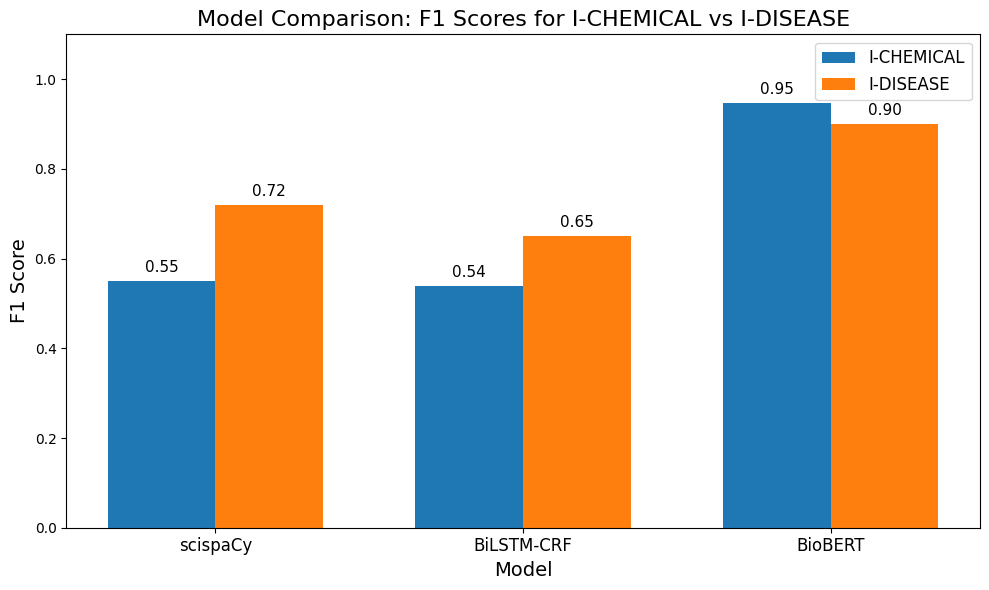

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ----- DATA -----
models = ["scispaCy", "BiLSTM-CRF", "BioBERT"]

# F1 scores for each label
f1_i_chemical = [0.55, 0.54, 0.9470]
f1_i_disease  = [0.72, 0.65, 0.8996]

# x locations
x = np.arange(len(models))
width = 0.35  # width of each bar

# ----- PLOT -----
plt.figure(figsize=(10, 6))

# Bars
plt.bar(x - width/2, f1_i_chemical, width, label="I-CHEMICAL")
plt.bar(x + width/2, f1_i_disease, width, label="I-DISEASE")

# Labels & title
plt.title("Model Comparison: F1 Scores for I-CHEMICAL vs I-DISEASE", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.xticks(x, models, fontsize=12)
plt.ylim(0, 1.1)

plt.legend(fontsize=12)

# Value labels on top of bars
for i, v in enumerate(f1_i_chemical):
    plt.text(i - width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)
for i, v in enumerate(f1_i_disease):
    plt.text(i + width/2, v + 0.02, f"{v:.2f}", ha='center', fontsize=11)

plt.tight_layout()
plt.savefig("i_chemical_vs_i_disease.png", dpi=300)
plt.show()
